# Ants optimization problem

1. Create experimental environment
2. Build algorithm
3. Set parameters and run experiments
4. Evaluate the results

## 1. Environment

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from copy import deepcopy
from tqdm import tqdm
from IPython.display import clear_output

import h5py
from google.colab import drive, files
import os

In [2]:
class Utilities():
  # constants:
  # Anthill state
  ORIGIN_STATE = -1
  # Food state
  TARGET_STATE = -2
  # Action-decision method
  MOVE_STOCHASTIC = 'stochastic'
  MOVE_GREEDY = 'greedy'
  MOVE_SOFTMAX = 'softmax'

  @staticmethod
  def stochastic_move(positions, pheromone_qs, a, b, nu=1, eps=1e-8):
    pheromone_qs = np.array(pheromone_qs) + eps
    norm_weight = 1 / np.sum(pheromone_qs ** a)
    probs = (pheromone_qs ** a) * norm_weight

    selected_idx = np.random.choice(np.arange(len(positions)), 1, p=probs) \
                            .item()
    # position_to_move
    return positions[selected_idx]

  @staticmethod
  def greedy_move(positions, pheromone_qs, eps=1e-8):
    pheromone_qs = np.array(pheromone_qs) + eps
    selected_idx = np.argmax(pheromone_qs)
    # position_to_move
    return positions[selected_idx]

  @staticmethod
  def softmax_move(positions, pheromone_qs, eps=1e-8):
    x_phero = np.exp(np.array(pheromone_qs) + eps).sum()
    selected_idx = np.argmax(x_phero / x_phero.sum())

    try:
        # position_to_move
        return positions[selected_idx]
    except:
        print("Checkout:", positions, selected_idx)
        raise Exception("Error")

  @staticmethod
  def manhattan_dist(p1, p2):
    leaps = abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])
    return leaps


class Environment(Utilities):
  """
  - Rectangle type and discrete positions environment.
  - Each point contains some information like quantity of pheromone, frequency of transit and transitability
  - There are special points start points (anthill) and end points (food).
  - Obstacles can be placed.
  """

  def __init__(
      self,
      w,
      h,
      alpha=-0.5,
      beta=1.5,
      rho=0.8,
      obstacles=None,
      special_points=None
      ):
    """
    - obstacles (dictionary): each element contains obstacle start,
    lenght and direction.
    """
    self.w = w
    self.h = h
    self.alpha = alpha
    self.beta = beta
    self.rho = rho
    self.obstacles = obstacles

    self.on_end = False
    self.on_first = True
    self.best_solution_steps = []

    self.pheromones = np.zeros((self.w, self.h))
    self.pheromones_last = self.pheromones.copy()

    self.frequency = np.zeros((self.w, self.h))

    X, Y = np.meshgrid(np.arange(self.w), np.arange(self.h))
    X = np.ravel(X)
    Y = np.ravel(Y)

    self.pos_to_state = {p: s for s, p in enumerate(zip(Y, X))}

    if not special_points:
      self.map_pos = list(zip(Y, X))
      is_boundary = lambda p: (0 in p) or ((self.w - 1) in p) or ((self.h - 1) in p)
      self.boundary = [self.pos_to_state[p] for p in self.map_pos if is_boundary(p)]

      anthill_s, food_s = np.random.choice(self.boundary,
                                          2,
                                          replace=False
                                          )

      self.state_to_pos = {s: p for p, s in self.pos_to_state.items()}
      self.pos_to_state[self.state_to_pos[anthill_s]] = -1
      self.pos_to_state[self.state_to_pos[food_s]] = -2
      self.state_to_pos = {s: p for p, s in self.pos_to_state.items()}
    else:
      anthill_p, food_p = special_points
      self.pos_to_state[anthill_p] = -1
      self.pos_to_state[food_p] = -2
      self.state_to_pos = {s: p for p, s in self.pos_to_state.items()}

  def environment_info(
      self,
      steps,
      steps_to_show=100,
      on_max=True,
      figsize=(12, 8)
      ):
    if (steps != 0) and (steps % steps_to_show == 0):
      #clear_output()
      print('+' * 40)
      print(env.state_to_pos[env.ORIGIN_STATE], env.state_to_pos[env.TARGET_STATE])
      x, y = self.state_to_pos[self.TARGET_STATE]
      print(self.pheromones[x, y])
      x, y = self.state_to_pos[self.ORIGIN_STATE]
      print(self.pheromones[x, y])

      f = plt.figure(figsize=figsize)

      plt.subplot(1, 1, 1)

      #max_val = np.abs(self.error_pheromones).max()
      sum_val = np.abs(self.error_pheromones).sum()
      rel_max_phero = 100 * np.round(self.error_pheromones / sum_val, 3)
      sns.heatmap(rel_max_phero, cmap='coolwarm', annot=True)

  def environment_start(self):
    env.best_solution_steps = []
    #self.pheromones *= 0
    #self.on_end = False

  def environment_end(self, pheros, steps, strategy='best', a=0.85):
    if not self.on_first:
      self.pheromones_last = self.pheromones.copy()
    else:
      self.on_first = False

    if strategy == 'sum':
      self.pheromones = self.pheromones * (1 - self.rho) + sum(pheros)
    elif strategy == 'best':
      min_step = np.argmin(steps)
      self.pheromones = self.pheromones * (1 - self.rho) + pheros[min_step]
      self.best_solution_steps.append(steps[min_step])
    elif strategy == 'ema':
      min_steps = np.argsort(steps)
      temp_pheromones = sum(a * pheros[x] * (1 - a)**i for i, x in enumerate(min_steps))
      self.pheromones = self.pheromones * (1 - self.rho) + temp_pheromones
      self.best_solution_steps.append(steps[min_steps[0]])

    self.error_pheromones = self.pheromones - self.pheromones_last

  def next_position(
      self,
      current_position,
      last_position,
      target,
      strategy='softmax'
      ) -> tuple[tuple[int, int], int]:
    x, y = current_position

    next_positions = ((np.clip(x, 0, self.w - 1),
                       np.clip(y - 1, 0, self.h - 1)), # up
                        (np.clip(x - 1, 0, self.w - 1),
                         np.clip(y, 0, self.h - 1)), # left
                          (np.clip(x, 0, self.w - 1),
                           np.clip(y + 1, 0, self. h - 1)), # down
                            (np.clip(x + 1, 0, self.w - 1),
                             np.clip(y, 0, self.h - 1))) # right

    # up, left, down, right
    neighbour_positions = [p for p in next_positions
                           if (p != current_position) and \
                              (p != last_position) and \
                              (p not in self.obstacles)]
    if not neighbour_positions:
        return last_position, self.pos_to_state[last_position]

    pheromones = [self.pheromones[x_n, y_n] for x_n, y_n in neighbour_positions]

    if strategy == self.MOVE_STOCHASTIC:
        next_position = self.stochastic_move(neighbour_positions,
                                             pheromones,
                                             self.alpha,
                                             self.beta
                                             )

    elif strategy == self.MOVE_GREEDY:
        next_position = self.greedy_move(neighbour_positions,
                                         pheromones)
    elif strategy == self.MOVE_SOFTMAX:
        next_position = self.softmax_move(neighbour_positions,
                                          pheromones)

    self.frequency[next_position[0],
                   next_position[1]] += 1

    next_state = self.pos_to_state[next_position]

    return next_position, next_state

class Ant(Utilities):
  terminal_count = {}
  def __init__(
      self,
      id,
      w,
      h,
      position,
      state,
      position_start,
      target,
      q,
      stop_threshold
      ):
    self.id = id
    self.w = w
    self.h = h
    self.position = position
    self.state = state
    self.target = target
    self.q = q
    self.stop_threshold = stop_threshold
    self.position_start = position_start
    self.terminal = False
    self.last_position = (-1, -1)
    self.last_state = -1

    self.pheromones = np.zeros((self.w, self.h))

  def ant_start(self):
    self.solution_steps = 0
    self.pheromones *= 0
    self.pheromones[self.position_start[0], self.position_start[1]] = self.q
    self.position = self.position_start
    self.target = self.TARGET_STATE
    self.terminal = False

  def ant_move(
      self,
      next_position,
      next_state
      ):

    self.last_position = self.position
    self.last_state = self.state

    self.pheromones[next_position[0], next_position[1]] += self.q

    self.position = next_position
    self.state = next_state

    #print(self.s, self.TARGET_STATE)
    if self.state == self.TARGET_STATE:
      self.target = self.ORIGIN_STATE
    elif self.state == self.ORIGIN_STATE:
      self.target = self.TARGET_STATE
      self.terminal = True
      self.terminal_count[self.id] = self.terminal_count.get(self.id, 0) + 1

    self.solution_steps += 1
    if not self.terminal and self.solution_steps > self.stop_threshold:
      self.terminal = True

Experiment several runs.

In [3]:
def run_experiment(
    n_runs=10,
    environment=None,
    ants=None,
    mode='stochastic',
    strategy='best',
    a=0.85,
    steps_show=5
    ):

  n_ants = len(ants)
  solutions = {}
  pheromones = {}

  # Experiment run
  for run in tqdm(range(n_runs)):

    environment.environment_start()
    environment.on_end = False
    for ant in ants:
      ant.ant_start()

    c_terminal = 0
    while not environment.on_end:
      for ant in ants:
        if not ant.terminal:
          new_p, new_s = environment.next_position(
              ant.position,
              ant.last_position,
              ant.target,
              strategy=mode
              )
          ant.ant_move(
              new_p,
              new_s
              )
          if ant.terminal:
            c_terminal += 1
      if c_terminal >= n_ants:
        environment.on_end = True

    total_phero = [a.pheromones for a in ants]
    total_steps = [a.solution_steps for a in ants]
    environment.environment_end(
        total_phero,
        total_steps,
        strategy=strategy,
        a=0.99
        )

    solutions[run] = deepcopy(environment.best_solution_steps)
    pheromones[run] = deepcopy(environment.pheromones.copy())
  environment.environment_info(run,
                               steps_show)
  return solutions, pheromones

Setup the parameters for the experiment.

In [4]:
# Parameters setup
n_runs = 5
w = 25
h = 25
n_ants = 5
alpha = -0.1
beta = 1
rho = 0.4
pheromone_quantity = 1
min_distance = np.sqrt(w ** 2 + h ** 2)
stop_threshold = 6 * np.ceil(min_distance)

special_points = [
    (0, 0), # origin
    (w - 1, h - 1), # end

]
obstacles = list(zip(10 * [(w - 1) // 2], tuple(np.arange(0, h // 2, 1))))
obstacles += [tuple(x) for x in np.random.randint(h // 4,
                                                  h // 2,
                                                  size=(50,
                                                        2))]
obstacles

[(12, 0),
 (12, 1),
 (12, 2),
 (12, 3),
 (12, 4),
 (12, 5),
 (12, 6),
 (12, 7),
 (12, 8),
 (12, 9),
 (7, 7),
 (9, 7),
 (7, 10),
 (6, 6),
 (7, 9),
 (10, 10),
 (7, 10),
 (9, 6),
 (10, 7),
 (8, 10),
 (10, 7),
 (8, 9),
 (9, 11),
 (6, 11),
 (6, 8),
 (7, 6),
 (6, 9),
 (6, 8),
 (7, 10),
 (6, 9),
 (10, 10),
 (10, 11),
 (6, 8),
 (7, 7),
 (8, 11),
 (9, 8),
 (9, 9),
 (11, 11),
 (8, 6),
 (11, 7),
 (7, 8),
 (10, 11),
 (6, 11),
 (7, 8),
 (8, 10),
 (6, 10),
 (10, 10),
 (9, 9),
 (6, 10),
 (9, 8),
 (10, 9),
 (8, 8),
 (6, 7),
 (11, 7),
 (11, 10),
 (11, 10),
 (7, 11),
 (9, 11),
 (9, 10),
 (7, 9)]

In [5]:
# Environment setup
env = Environment(w,
                  h,
                  alpha,
                  beta,
                  rho,
                  obstacles,
                  special_points
                  )
env.environment_start()
start_s = env.TARGET_STATE
start_p = env.state_to_pos[start_s]

# Ants instantiation setup
Ant.terminal_count = {}
ants = [Ant(i, w, h, start_p, start_s, start_p, start_s, pheromone_quantity, stop_threshold) for i in range(n_ants)]

In [6]:
# Run experiment with only runs
sol_run, phero_run = run_experiment(n_runs,
                                    environment=env,
                                    ants=ants,
                                    mode='softmax',
                                    strategy='ema')
avg_pheromone = np.array(list(phero_run.values()))
avg_pheromone.shape

100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


(5, 25, 25)

#### Evaluation of results

Start: (0, 0) | end: (24, 24)


<Axes: >

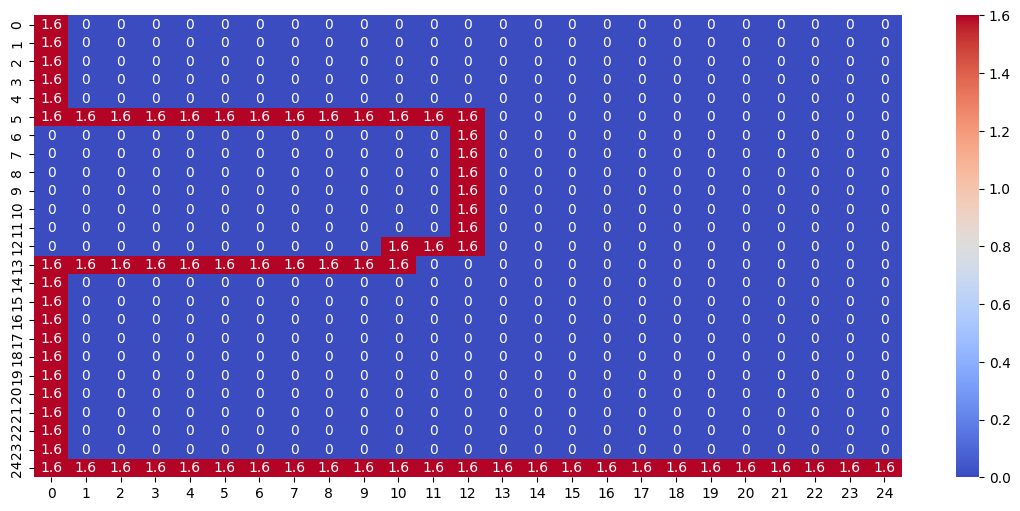

In [7]:
# Average pheromone amount in last run
print(f'Start: {env.state_to_pos[-1]} | end: {env.state_to_pos[-2]}')
avg_pheromone = list(phero_run.values())[1]

f = plt.figure(figsize=(14, 6))
sns.heatmap(avg_pheromone, cmap='coolwarm', annot=True)

Start: (0, 0) | end: (24, 24)
Manhattan distance from origin to end: 48


<Axes: >

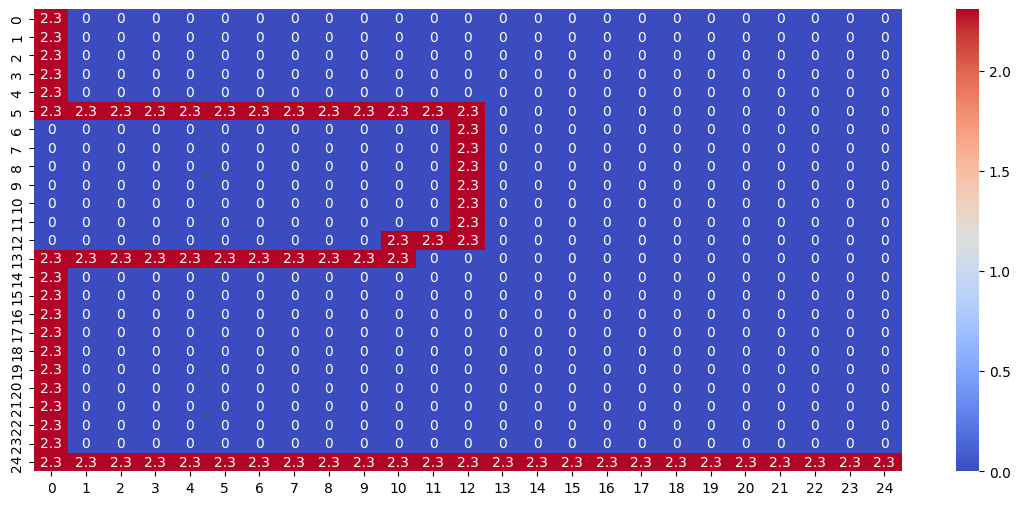

In [8]:
# Absolute amount of pheromone in each cell
print(f'Start: {env.state_to_pos[-1]} | end: {env.state_to_pos[-2]}')
print('Manhattan distance from origin to end:',
      env.manhattan_dist(env.state_to_pos[-1],
                         env.state_to_pos[-2]))

f = plt.figure(figsize=(14, 6))
sns.heatmap(env.pheromones,
            cmap='coolwarm',
            annot=True)

In [9]:
# Percentiles
new_percentiles = (0.6, 0.75, 0.9)
df_sol_run = pd.DataFrame(sol_run)
df_sol_run.describe(percentiles=new_percentiles)

,0,1,2,3,4
count,1.0,1.0,1.0,1.0,1.0
mean,72.0,72.0,72.0,72.0,72.0
std,NaN,NaN,NaN,NaN,NaN
min,72.0,72.0,72.0,72.0,72.0
50%,72.0,72.0,72.0,72.0,72.0
60%,72.0,72.0,72.0,72.0,72.0
75%,72.0,72.0,72.0,72.0,72.0
90%,72.0,72.0,72.0,72.0,72.0
max,72.0,72.0,72.0,72.0,72.0


Minimum number of steps solutions per step number

In [10]:
df_sol_run.min(axis=0).sort_values()

0    72
1    72
2    72
3    72
4    72
dtype: int64

In [11]:
(df_sol_run.sum(axis=0) / 50).describe()

count    5.00
mean     1.44
std      0.00
min      1.44
25%      1.44
50%      1.44
75%      1.44
max      1.44
dtype: float64

Though some positions are frequently visited, that does not mean they belong
to good or optimal paths. It is important to focus on agents which take
the least number of movements (shorthest path). Meanwhile, most of agents could
take longer paths and visit unoptimal and irrelavant positions with high frequency.

In [12]:
norm_factor = env.frequency.sum()
freq_rel = 100 * np.round(env.frequency / norm_factor, 3)
freq_rel

array([[1.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [1.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [1.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [1.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [1.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1.4,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
      

Evaluate the importance of parameters, such as alpha or number of agents,
in exploring environments with different size; multiple obstacles; necessary
time steps, pheromone evaporation rate.

In [13]:
# Parameters setup
n_runs = 10
w = 10
h = 10
beta = 1
pheromone_quantity = 1
stop_threshold = 3 * np.ceil(np.sqrt(w ** 2 + h ** 2))

special_points = [
    (0, 0), # Origin
     (w - 1, h - 1) # End
     ]

obstacles = list(zip(10 * [(w - 1) // 2], tuple(np.arange(0, h // 2, 1))))
obstacles += [tuple(x) for x in np.random.randint(h // 4,
                                                  h // 2,
                                                  size=(50,
                                                        2))]

# Experimental parameters
alphas = -np.linspace(0.1, 0.9, 5)
n_agents_list = np.arange(5, 20 + 5, 5)
rhos = np.linspace(0.1, 0.9, 5)

alphas, n_agents_list, rhos

(array([-0.1, -0.3, -0.5, -0.7, -0.9]),
 array([ 5, 10, 15, 20]),
 array([0.1, 0.3, 0.5, 0.7, 0.9]))

In [14]:
result_solutions = {}
result_pheromones = {}
indices = []

for alpha in alphas:
  for n_agents in n_agents_list:
    for rho in rhos:
      index = '_'.join([str(round(x, 2)) for x in [alpha, n_agents, rho]])
      indices.append(index)
      # Setup agents and environment
      env = Environment(w,
                        h,
                        alpha,
                        beta,
                        rho,
                        obstacles,
                        special_points=special_points)

      env.environment_start()
      start_s = env.TARGET_STATE
      start_p = env.state_to_pos[start_s]

      Ant.terminal_count = {}
      ants = [Ant(i, w, h, start_p, start_s, start_p, start_s, pheromone_quantity, stop_threshold) for i in range(n_agents)]

      # Run experiment
      sol_run, phero_run = run_experiment(n_runs,
                                          environment=env,
                                          ants=ants,
                                          mode='softmax')
      avg_pheromone = np.mean(np.array(list(phero_run.values())), axis=-0)

      result_solutions[index] = sol_run
      result_pheromones[index] = avg_pheromone

100%|██████████| 10/10 [00:00<00:00, 10.03it/s]


Tensor shape: (100, 10, 10)


<Axes: >

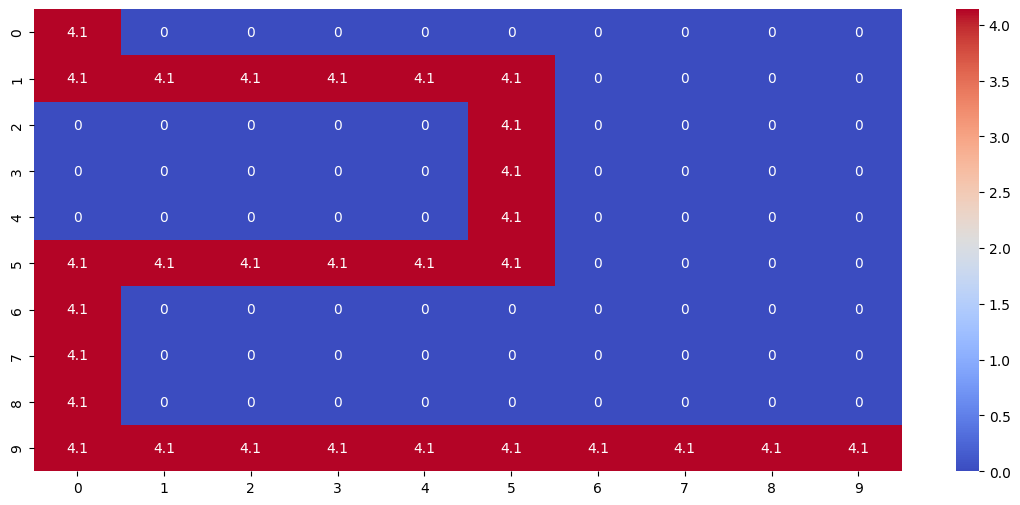

In [17]:
# Absolute amount of pheromone in best run
pheromones_tensor = np.array(list(result_pheromones.values()))
print('Tensor shape:', pheromones_tensor.shape)

# Calculate best run
best_run = pheromones_tensor.mean(axis=(1, 2)).argmax()

f = plt.figure(figsize=(14, 6))
sns.heatmap(pheromones_tensor[best_run],
            cmap='coolwarm',
            annot=True)

In [18]:
# Stack step-solutions to make a dataframe
df_solutions = []
for x in result_solutions:
  df_solution = pd.DataFrame(result_solutions[x])
  df_solutions.append(pd.DataFrame(df_solution))

data = list(map(lambda x: x.min(), df_solutions))

# Make dataframe
df_min_solutions = pd.DataFrame(data,
                                index=indices)
_, n_tries = df_min_solutions.shape
df_min_solutions.columns = (('run_' + str(x) for x in range(n_tries)))
df_min_solutions.index.names = ['alpha_agents_rho']

# Make stats summary
#df_min_solutions_summary = df_min_solutions.agg(['mean', 'std'],
#                                                axis=1) \
#                                           .sort_values('mean')
#df_min_solutions_summary.rename(columns={'mean': 'mean_step',
#                                         'std': 'std_step'},
#                                inplace=True)
df_min_solutions_summary = df_min_solutions.describe().T

#df_min_solutions.mean(axis=1).sort_values()
df_min_solutions_summary

,count,mean,std,min,25%,50%,75%,max
run_0,100.0,28.0,0.0,28.0,28.0,28.0,28.0,28.0
run_1,100.0,28.0,0.0,28.0,28.0,28.0,28.0,28.0
run_2,100.0,28.0,0.0,28.0,28.0,28.0,28.0,28.0
run_3,100.0,28.0,0.0,28.0,28.0,28.0,28.0,28.0
run_4,100.0,28.0,0.0,28.0,28.0,28.0,28.0,28.0
run_5,100.0,28.0,0.0,28.0,28.0,28.0,28.0,28.0
run_6,100.0,28.0,0.0,28.0,28.0,28.0,28.0,28.0
run_7,100.0,28.0,0.0,28.0,28.0,28.0,28.0,28.0
run_8,100.0,28.0,0.0,28.0,28.0,28.0,28.0,28.0
run_9,100.0,28.0,0.0,28.0,28.0,28.0,28.0,28.0


In [19]:
file_name = 'ants_algo_min_solutions_summary.csv'
df_min_solutions_summary.to_csv('ants_algo_min_solutions_summary.csv')